In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf

from radar_processing.data_ingestion import create_df
from radar_processing.data_visualization import visualize_and_save_df
from radar_processing.data_preprocessing import scale_df, filter_df, clip_df

import seaborn as sns

from os import walk

import math
from math import floor

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

cwd = os.getcwd()
print(cwd)

C:\Users\luisg\radar_acquisitions
C:\Users\luisg\radar_acquisitions


# Useful functions

In [2]:
def bbox_to_rect(bbox):
    """Convert bounding box to matplotlib format"""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(xy=(-1, bbox[0]), width=202,
                             height=bbox[1] - bbox[0], fill=False,
                             edgecolor='red', linewidth=1)

def bbox_borders_to_center(bbox):
    """Convert from (lower border, upper-border) to (center, height)"""
    x1, x2 = bbox[0], bbox[1]
    cx = (x1 + x2) / 2
    h = x2 - x1
    bbox = [cx, h]
    return bbox

def box_center_to_borders(bbox):
    """Convert from (center, height) to (lower border, upper-border)"""
    cx, h = bbox[0], bbox[1]
    x1 = cx - 0.5 * h
    x2 = cx + 0.5 * h
    bbox = [x1, x2]
    return bbox

# Dataset loading

In [3]:
pkl_path = f"./pickle/df_luis_5_bbox.pkl"
df = pd.read_pickle(pkl_path)
df

,Id,presence,data,fftdata,bbox
0,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 8.034872939559035e-...","[[-160.2950249133561, -194.72275445022544, -18...","[14, 42]"
1,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.5555243542351457e...","[[-161.43283565674847, -190.55028151463148, -1...","[46, 72]"
2,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 8.45331887376697e-1...","[[-173.09489706100504, -200.58769603161903, -2...","[15, 47]"
3,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 3.8003771514947853e...","[[-163.1541434009199, -182.87782129028682, -18...","[71, 97]"
4,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0471688198795585e...","[[-160.0532420278023, -181.14059388583507, -18...","[42, 74]"
...,...,...,...,...,...
76,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 4.762209259274762e-...","[[-162.53141628497448, -190.06063901683828, -1...","[128, 148]"
77,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.1939769319724238e...","[[-161.31621754575863, -186.35465427231804, -1...","[126, 148]"
78,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.3622539971619137e...","[[-162.35059763677089, -185.6312602737847, -18...","[77, 105]"
79,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 7.3050508590492e-10...","[[-159.20551436727033, -196.07560131234337, -1...","[22, 45]"


## Convert bbox into tensor

In [4]:
bboxes = df['bbox']
center_height = []

for box in bboxes:
    box = bbox_borders_to_center(box)
    center_height.append(box)
    
print(center_height)

[[28.0, 28], [59.0, 26], [31.0, 32], [84.0, 26], [58.0, 32], [58.5, 25], [40.0, 20], [35.5, 25], [19.0, 22], [83.5, 21], [26.5, 17], [27.0, 20], [25.0, 20], [79.5, 17], [47.5, 21], [51.0, 22], [73.0, 24], [37.5, 31], [40.5, 35], [122.0, 16], [48.5, 23], [94.5, 29], [69.0, 22], [20.0, 22], [94.0, 24], [51.5, 31], [62.5, 33], [73.0, 28], [109.0, 22], [54.5, 23], [78.5, 31], [80.5, 31], [52.0, 24], [45.0, 26], [66.5, 23], [72.5, 21], [34.0, 24], [51.5, 21], [12.0, 24], [12.0, 24], [10.5, 21], [96.5, 27], [86.0, 28], [79.0, 22], [90.0, 20], [101.5, 29], [94.0, 32], [23.5, 21], [71.5, 21], [82.0, 26], [38.0, 20], [67.5, 21], [50.0, 24], [100.0, 24], [70.0, 24], [62.5, 21], [37.5, 19], [28.0, 20], [27.0, 18], [82.0, 24], [36.0, 16], [15.5, 21], [14.5, 23], [17.0, 26], [46.5, 17], [19.5, 21], [92.5, 15], [26.5, 21], [42.0, 20], [55.0, 22], [41.0, 18], [40.5, 19], [21.0, 20], [68.5, 19], [107.0, 26], [95.0, 30], [138.0, 20], [137.0, 22], [91.0, 28], [33.5, 23], [13.5, 17]]


In [5]:
bboxes=[]
for box in center_height:
    img_boxes=[]
    for i in range(0,7):
        segment_box=[]
        if math.floor(box[0]/21) == i:
            segment_box = [1,((box[0]-21*math.floor(box[0]/21))/21),(box[1]/21)]
        else:
            segment_box = [0,0,0]
        img_boxes.append(segment_box)
    bboxes.append(img_boxes)

print(bboxes)

[[[0, 0, 0], [1, 0.3333333333333333, 1.3333333333333333], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [1, 0.8095238095238095, 1.2380952380952381], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [1, 0.47619047619047616, 1.5238095238095237], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0.0, 1.2380952380952381], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [1, 0.7619047619047619, 1.5238095238095237], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [1, 0.7857142857142857, 1.1904761904761905], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [1, 0.9047619047619048, 0.9523809523809523], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [1, 0.6904761904761905, 1.1904761904761905], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[1, 0.9047619047619048, 1.0476190476190477], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0

# Check calculations

In [6]:
array=[]
for image in bboxes:
    for i in range(0,7):
        if image[i] != [0,0,0]:
            center = (image[i][1] + i)*21
            height = image[i][2]*21
            array.append([round(center,2),round(height,2)])
            
print(array)

[[28.0, 28.0], [59.0, 26.0], [31.0, 32.0], [84.0, 26.0], [58.0, 32.0], [58.5, 25.0], [40.0, 20.0], [35.5, 25.0], [19.0, 22.0], [83.5, 21.0], [26.5, 17.0], [27.0, 20.0], [25.0, 20.0], [79.5, 17.0], [47.5, 21.0], [51.0, 22.0], [73.0, 24.0], [37.5, 31.0], [40.5, 35.0], [122.0, 16.0], [48.5, 23.0], [94.5, 29.0], [69.0, 22.0], [20.0, 22.0], [94.0, 24.0], [51.5, 31.0], [62.5, 33.0], [73.0, 28.0], [109.0, 22.0], [54.5, 23.0], [78.5, 31.0], [80.5, 31.0], [52.0, 24.0], [45.0, 26.0], [66.5, 23.0], [72.5, 21.0], [34.0, 24.0], [51.5, 21.0], [12.0, 24.0], [12.0, 24.0], [10.5, 21.0], [96.5, 27.0], [86.0, 28.0], [79.0, 22.0], [90.0, 20.0], [101.5, 29.0], [94.0, 32.0], [23.5, 21.0], [71.5, 21.0], [82.0, 26.0], [38.0, 20.0], [67.5, 21.0], [50.0, 24.0], [100.0, 24.0], [70.0, 24.0], [62.5, 21.0], [37.5, 19.0], [28.0, 20.0], [27.0, 18.0], [82.0, 24.0], [36.0, 16.0], [15.5, 21.0], [14.5, 23.0], [17.0, 26.0], [46.5, 17.0], [19.5, 21.0], [92.5, 15.0], [26.5, 21.0], [42.0, 20.0], [55.0, 22.0], [41.0, 18.0], [

In [7]:
print(center_height == array)

True


# Add preprocessed data to the dataset

In [8]:
df['bbox_center'] = center_height
df

,Id,presence,data,fftdata,bbox,bbox_center
0,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 8.034872939559035e-...","[[-160.2950249133561, -194.72275445022544, -18...","[14, 42]","[28.0, 28]"
1,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.5555243542351457e...","[[-161.43283565674847, -190.55028151463148, -1...","[46, 72]","[59.0, 26]"
2,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 8.45331887376697e-1...","[[-173.09489706100504, -200.58769603161903, -2...","[15, 47]","[31.0, 32]"
3,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 3.8003771514947853e...","[[-163.1541434009199, -182.87782129028682, -18...","[71, 97]","[84.0, 26]"
4,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0471688198795585e...","[[-160.0532420278023, -181.14059388583507, -18...","[42, 74]","[58.0, 32]"
...,...,...,...,...,...,...
76,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 4.762209259274762e-...","[[-162.53141628497448, -190.06063901683828, -1...","[128, 148]","[138.0, 20]"
77,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.1939769319724238e...","[[-161.31621754575863, -186.35465427231804, -1...","[126, 148]","[137.0, 22]"
78,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.3622539971619137e...","[[-162.35059763677089, -185.6312602737847, -18...","[77, 105]","[91.0, 28]"
79,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 7.3050508590492e-10...","[[-159.20551436727033, -196.07560131234337, -1...","[22, 45]","[33.5, 23]"


In [9]:
df['bbox_segmented'] = bboxes
df

,Id,presence,data,fftdata,bbox,bbox_center,bbox_segmented
0,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 8.034872939559035e-...","[[-160.2950249133561, -194.72275445022544, -18...","[14, 42]","[28.0, 28]","[[0, 0, 0], [1, 0.3333333333333333, 1.33333333..."
1,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.5555243542351457e...","[[-161.43283565674847, -190.55028151463148, -1...","[46, 72]","[59.0, 26]","[[0, 0, 0], [0, 0, 0], [1, 0.8095238095238095,..."
2,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 8.45331887376697e-1...","[[-173.09489706100504, -200.58769603161903, -2...","[15, 47]","[31.0, 32]","[[0, 0, 0], [1, 0.47619047619047616, 1.5238095..."
3,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 3.8003771514947853e...","[[-163.1541434009199, -182.87782129028682, -18...","[71, 97]","[84.0, 26]","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
4,C:\Users\luisg\radar_acquisitions\recordings\a...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0471688198795585e...","[[-160.0532420278023, -181.14059388583507, -18...","[42, 74]","[58.0, 32]","[[0, 0, 0], [0, 0, 0], [1, 0.7619047619047619,..."
...,...,...,...,...,...,...,...
76,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 4.762209259274762e-...","[[-162.53141628497448, -190.06063901683828, -1...","[128, 148]","[138.0, 20]","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
77,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.1939769319724238e...","[[-161.31621754575863, -186.35465427231804, -1...","[126, 148]","[137.0, 22]","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
78,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.3622539971619137e...","[[-162.35059763677089, -185.6312602737847, -18...","[77, 105]","[91.0, 28]","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [..."
79,C:\Users\luisg\radar_acquisitions\recordings\b...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 7.3050508590492e-10...","[[-159.20551436727033, -196.07560131234337, -1...","[22, 45]","[33.5, 23]","[[0, 0, 0], [1, 0.5952380952380952, 1.09523809..."


# Check results and save

In [17]:
index = 70

71


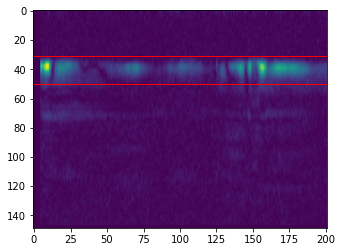

In [20]:
print(index)
img = df['data'][index]
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(df['bbox'][index]))

[[31.0, 50.0]]


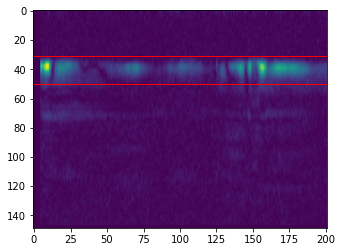

In [21]:
image = []
for row in df['bbox_segmented'][index]:
    segment = []
    for value in row:
        segment.append(round(abs(value),2))
    image.append(segment)
total = image

best_segment = []
maxim = 0
for i in range(0,7):
    if image[i][0] > maxim:
        maxim = image[i][0]
best_segment = maxim
#print(best_segment)

array=[]
for i in range(0,7):
    if df['bbox_segmented'][index][i][0] == best_segment:
        center = (df['bbox_segmented'][index][i][1] + i)*21
        height = df['bbox_segmented'][index][i][2]*21
        array.append([round(center,2),round(height,2)])
            
#print(array)

borders = []

for box in array:
    box = box_center_to_borders(box)
    borders.append(box)
    
print(borders)

fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(borders[0]))

index+=1

In [22]:
pickle_dir = os.path.join(cwd, "pickle")
if not os.path.exists(pickle_dir):
    os.makedirs(pickle_dir)
path = os.path.join(pickle_dir, "df_luis_5_bbox_segmented.pkl")
df.to_pickle(path)